### Imports

In [1]:
from qbo import QBO
from qmc import QMC
import numpy as np
from sklearn import svm
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeWashington
import matplotlib.pyplot as plt

### Experiment Config

In [ ]:
# Quantum simulation device
device = FakeWashington()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

# Quantum params
quantum_noise = False
max_iter = 5000 # 20 min runtime for 1000, 1 hr for 5000
uncertainty_dim = 6 # number of qubits to use (exponentially increases runtime)

In [3]:
# Lookahead prior sampling
dim1 = np.linspace(0, 1, 10) # add these alongside prior domain. treat as arb gridspace
dim2 = np.linspace(0, 1, 10)
dim = 2
domain = []
for a in dim1:
    for b in dim2:
        domain.append([a, b])
domain = np.array(domain)
ls = np.array([0.2, 0.2]) # length scale
v_kernel = 0.5
obs_noise = 0.05 ** 2
M_target = 200

# RBF kernel
s = np.random.multivariate_normal(np.zeros(dim), 1 / (ls**2) * np.identity(dim), M_target)
b = np.random.uniform(0, 2 * np.pi, M_target)

fourier_features = {
    "s": s, # frequencies
    "b": b, # phases
    "v_kernel": v_kernel,
    "obs_noise": obs_noise,
    "domain": domain
}

In [4]:
# Train-Test data
diabetes_data = pd.read_csv("data/diabetes.csv")
label = np.array(diabetes_data["Outcome"])
features = np.array(diabetes_data.iloc[:, :-1])
X_train, X_test, Y_train, Y_test = train_test_split(features, label, test_size=0.3, stratify=label, random_state=0)
n_ft = X_train.shape[1]
n_classes = 2

### QMC Circuit

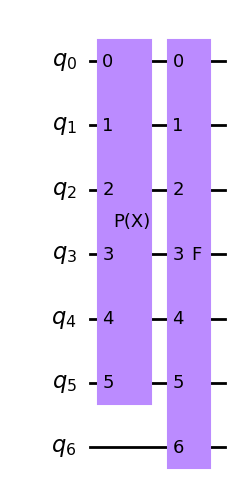

In [5]:
dummy_qmc = QMC(num_uncertainty=uncertainty_dim, means=1.0)
dummy_qmc.mc_circuit.draw(output="mpl")

### Model Priors and Train-Test Loop

In [6]:
def reward_function(param, eps, obs_noise):
    # Define priors (vary these)
    parameter_range = [[1e-4, 1.0], [1e-4, 1.0]]
    C_ = param[0]
    C = C_ * (parameter_range[0][1] - parameter_range[0][0]) + parameter_range[0][0]
    gam_ = param[1]
    gam = gam_ * (parameter_range[1][1] - parameter_range[1][0]) + parameter_range[1][0]

    # Train and estimate
    clf = svm.SVC(kernel="rbf", C=C, gamma=gam, probability=True)
    clf.fit(X_train, Y_train)
    pred = clf.predict(X_test)
    acc = np.count_nonzero(pred == Y_test) / len(Y_test)
    
    # Update beliefs via QBO and QMC
    qmc = QMC(num_uncertainty=uncertainty_dim, means=acc, obs_noise=obs_noise)
    result, queries = qmc.estimate(eps)
    return result.estimation_processed, acc, queries

### Apply QBO with Q-LinUCB

In [7]:
pbounds = {}
for i in range(dim):
    pbounds["x" + str(i+1)] = (0, 1)

ts = np.arange(1, max_iter)
beta_t = 1 + np.sqrt(np.log(ts) ** 2)

quantum_BO = None
bandits = True
all_lin_res = []
for itr in range(5):
    print("Optimization Round", itr + 1)
    np.random.seed(itr)

    quantum_BO = QBO(
        reward_func=reward_function,
        pbounds=pbounds,
        beta_t=beta_t,
        random_features=fourier_features,
        bandits=bandits,
        domain=domain
    )
    quantum_BO.maximize(n_iter=max_iter, init_points=1)
    all_lin_res.append(quantum_BO.res)

Optimization Round 1
Shot 0 ------ x_t: [1. 1.], y_t: 0.6661300630427467
Shot 10 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 20 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 30 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 40 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 50 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 60 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 70 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 80 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 90 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 100 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 110 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 120 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 130 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 140 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 150 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 160 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 170 ------ x_t: [1. 0.], y_t: 0.7594287960928843
Shot 180 ------ x_

In [8]:
# res_lin_ucb = quantum_BO.res
# print(res_lin_ucb["max"])

### Apply QBO with Q-GP-UCB (ours)

In [9]:
pbounds = {}
for i in range(dim):
    pbounds["x" + str(i+1)] = (0, 1)

ts = np.arange(1, max_iter)
beta_t = 1 + np.sqrt(np.log(ts) ** 2)

quantum_BO = None
bandits = False
all_gp_res = []
for itr in range(5):
    print("Optimization Round", itr + 1)
    np.random.seed(itr)

    quantum_BO = QBO(
        reward_func=reward_function,
        pbounds=pbounds,
        beta_t=beta_t,
        random_features=fourier_features,
        bandits=bandits,
        domain=domain
    )
    quantum_BO.maximize(n_iter=max_iter, init_points=1)
    all_gp_res.append(quantum_BO.res)

Optimization Round 1
Shot 0 ------ x_t: [0.33333333 0.55555556], y_t: 0.6661300630427467
Shot 10 ------ x_t: [1. 0.], y_t: 0.6661300630427467
Shot 20 ------ x_t: [0.22222222 0.88888889], y_t: 0.6661300630427467
Shot 30 ------ x_t: [0.66666667 0.88888889], y_t: 0.7751518126104544
Shot 40 ------ x_t: [0.77777778 0.        ], y_t: 0.6661300630427467
Shot 50 ------ x_t: [0.66666667 0.        ], y_t: 0.759595368835899
Optimization Round 2
Shot 0 ------ x_t: [0.22222222 0.66666667], y_t: 0.6661300630427467
Shot 10 ------ x_t: [0.88888889 0.        ], y_t: 0.7594287960928843
Shot 20 ------ x_t: [1. 1.], y_t: 0.6661300630427467
Shot 30 ------ x_t: [0.         0.33333333], y_t: 0.6661300630427467
Shot 40 ------ x_t: [0.22222222 0.11111111], y_t: 0.6661300630427467
Shot 50 ------ x_t: [0.33333333 0.        ], y_t: 0.765477459471503
Optimization Round 3
Shot 0 ------ x_t: [0.22222222 0.        ], y_t: 0.7672903415265213
Shot 10 ------ x_t: [1.         0.55555556], y_t: 0.6661300630427467
Shot 20 

In [10]:
# res_gp_ucb = quantum_BO.res
# print(res_gp_ucb["max"])

### Cumulative Regret

In [11]:
# Norm const
f_max = 0
for i in range(5):
    gp_fvalues = all_gp_res[i]["all"]["f_values"]
    lin_fvalues = all_lin_res[i]["all"]["f_values"]
    f_max = max(f_max, max(gp_fvalues), max(lin_fvalues))

In [12]:
# Collect total cumulative regrets
all_gp_regrets = []
all_lin_regrets = []
min_sims = max_iter
for gp_res, lin_res in zip(all_gp_res, all_lin_res):
    gp_values = gp_res["all"]["f_values"]
    gp_queries = gp_res["all"]["track_queries"]
    lin_values = lin_res["all"]["f_values"]
    lin_queries = lin_res["all"]["track_queries"]
    
    gp_values_new = []
    lin_values_new = []
    for i in range(len(gp_values)):
        gp_values_new += list(np.repeat(gp_values[i], gp_queries[i]))
    for i in range(len(lin_values)):
        lin_values_new += list(np.repeat(lin_values[i], lin_queries[i]))
    
    gp_values = np.squeeze(f_max - np.array(gp_values_new))
    lin_values = np.squeeze(f_max - np.array(lin_values_new))
    gp_values_acc = np.cumsum(gp_values)
    lin_values_acc = np.cumsum(lin_values)
    
    min_sims = min(min_sims, len(gp_values_acc))
    min_sims = min(min_sims, len(lin_values_acc))
    
    all_gp_regrets.append(gp_values_acc)
    all_lin_regrets.append(lin_values_acc)

all_gp_regrets = np.array([a[:min_sims] for a in all_gp_regrets])
all_lin_regrets = np.array([a[:min_sims] for a in all_lin_regrets])

In [13]:
# Compute means and confidence range
all_gp_regrets_mean = np.mean(all_gp_regrets, axis=0)
all_lin_regrets_mean = np.mean(all_lin_regrets, axis=0)

all_gp_regrets_stderr = np.std(all_gp_regrets, axis=0) / (np.sqrt(len(all_gp_regrets)))
all_lin_regrets_stderr = np.std(all_lin_regrets, axis=0) / (np.sqrt(len(all_lin_regrets)))

all_gp_regrets_ub = all_gp_regrets_mean + all_gp_regrets_stderr
all_gp_regrets_lb = all_gp_regrets_mean - all_gp_regrets_stderr
all_lin_regrets_ub = all_lin_regrets_mean + all_lin_regrets_stderr
all_lin_regrets_lb = all_lin_regrets_mean - all_lin_regrets_stderr

In [14]:
print(all_gp_regrets_mean.shape)
print(all_lin_regrets_mean.shape)

(5000,)
(5000,)


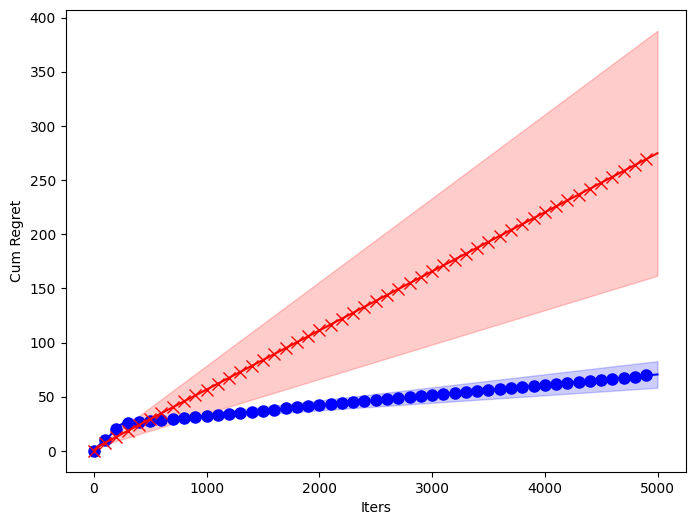

In [15]:
# NOTE: Lower cum regret is better. Q-QP-UCB wins out as iters increases

plt.figure(figsize=(8, 6))
ts = np.arange(0, min_sims)

# Plot Q-GP-UCB regrets
plt.fill_between(ts, all_gp_regrets_ub, all_gp_regrets_lb, color="b", alpha=0.2)
plt.plot(ts, all_gp_regrets_mean, "b", marker="o", markersize=8, markevery=100)

# Plot Q-LIN-UCB regrets
plt.fill_between(ts, all_lin_regrets_ub, all_lin_regrets_lb, color="r", alpha=0.2)
plt.plot(ts, all_lin_regrets_mean, "r", marker="x", markersize=8, markevery=100)

plt.ylabel("Cum Regret")
plt.xlabel("Iters")
plt.show()